In [ ]:
# develop-landau-fitting-with-bias.ipynb
#
# Bryan Daniels
# 2024/3/22
#
# Adding a bias term to the landau analysis.

In [1]:
from importlib import reload

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import landauAnalysis
reload(landauAnalysis)

<module 'landauAnalysis' from '/Users/bdaniel6/packages/landau/landau/landauAnalysis.py'>

In [4]:
landauAnalysis.normalizationZ(2,2,0.1,0.1,90)

1.2329204921744008

In [29]:
from matplotlib import pyplot as plt

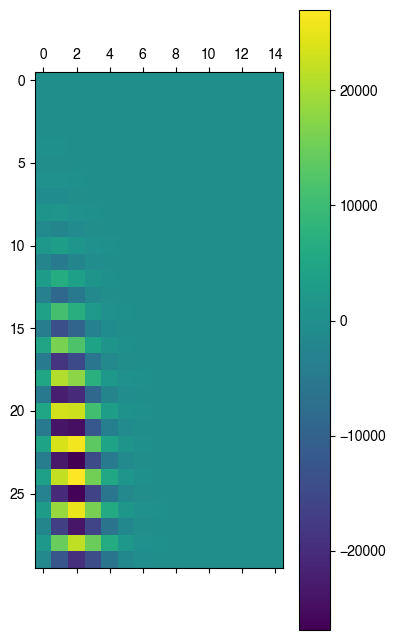

In [54]:
plt.matshow(f1*f2*f3)
plt.colorbar()

In [35]:
(f1*f2*f3)[-1,-1]

-4.27321937242563e-22

# fitting routine

In [106]:
reload(landauAnalysis)

<module 'landauAnalysis' from '/Users/bdaniel6/packages/landau/landau/landauAnalysis.py'>

In [9]:
TEST_DATA_1D = np.transpose([[ 1,2,2,3,6,7,7,9 ]])

In [10]:
TEST_DATA_1D

array([[1],
       [2],
       [2],
       [3],
       [6],
       [7],
       [7],
       [9]])

In [11]:
def log_likelihood(x_list,c,h,d,numu,maxorder=30):
    """
    x_list should be a list of single numbers of length num_samples
    """
    mu = np.mean(x_list)
    Jnu = 1./np.var(x_list)
    Z = landauAnalysis.normalizationZ(Jnu,c,h,d,maxorder)
    log_likelihoods = [ landauAnalysis.LandauTransitionDistributionRelativeLogPDF(x,mu+numu,Jnu,c,h,d) - np.log(Z) for x in x_list ]
    return np.sum(log_likelihoods)

In [32]:
def log_likelihood_difference_from_gaussian(x_list,c,h,d,numu,maxorder=30):
    """
    x_list should be a list of single numbers of length num_samples
    """
    mu = np.mean(x_list)
    Jnu = 1./np.var(x_list)
    landau_ll = log_likelihood(x_list,c,h,d,numu,maxorder)
    gaussian_ll = np.sum([ landauAnalysis.GaussianDistributionLogPDF(x,mu,Jnu) for x in x_list ])
    return landau_ll - gaussian_ll

In [12]:
log_likelihood(TEST_DATA_1D[:,0],1,1,1,0.1)

-20.934514165200724

In [13]:
import scipy.optimize

In [39]:
# first try optimizing with h held at zero (or near zero)
# (try to match what we get with old mathematica code --- see test/test_landau.py)
hfixed = +1e-10
func = lambda params: -log_likelihood_difference_from_gaussian(TEST_DATA_1D[:,0],params[0],hfixed,params[1],params[2],maxorder=30)
cinit,dinit,numuinit = 1,1,0
#cbounds,dbounds,numubounds = (-100,100),(0.001,100),(-100,100)
scipy.optimize.minimize(func,(cinit,dinit,numuinit))
                      # bounds=(cbounds,dbounds,numubounds))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -2.535390435538183
        x: [-4.707e+00  3.898e+00  2.249e-01]
      nit: 12
      jac: [ 0.000e+00  4.768e-07 -7.153e-07]
 hess_inv: [[ 1.002e+01 -7.637e+00 -2.540e-02]
            [-7.637e+00  6.549e+00 -9.922e-03]
            [-2.540e-02 -9.922e-03  1.374e-01]]
     nfev: 56
     njev: 14

In [40]:
func = lambda params: -log_likelihood_difference_from_gaussian(TEST_DATA_1D[:,0],*params,maxorder=30)
cinit,hinit,dinit,numuinit = 1,0.001,1,0
scipy.optimize.minimize(func,(cinit,hinit,dinit,numuinit))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -2.5656708617830546
        x: [-4.691e+00  2.329e-01  3.887e+00  3.174e-01]
      nit: 15
      jac: [-2.384e-07 -4.768e-07  0.000e+00  0.000e+00]
 hess_inv: [[ 9.030e+00  2.336e-01 -7.113e+00  2.892e-01]
            [ 2.336e-01  9.048e-01 -9.570e-02  3.547e-01]
            [-7.113e+00 -9.570e-02  6.274e+00 -2.292e-01]
            [ 2.892e-01  3.547e-01 -2.292e-01  2.805e-01]]
     nfev: 80
     njev: 16

In [37]:
def maximize_log_likelihood(x_list):
    func = lambda params: -log_likelihood_difference_from_gaussian(x_list,*params,maxorder=30)
    cinit,hinit,dinit,numuinit = 1,1e-3,1,0
    return scipy.optimize.minimize(func,(cinit,hinit,dinit,numuinit))

In [38]:
maximize_log_likelihood(TEST_DATA_1D[:,0])

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -2.5656708617830546
        x: [-4.691e+00  2.329e-01  3.887e+00  3.174e-01]
      nit: 15
      jac: [-2.384e-07 -4.768e-07  0.000e+00  0.000e+00]
 hess_inv: [[ 9.030e+00  2.336e-01 -7.113e+00  2.892e-01]
            [ 2.336e-01  9.048e-01 -9.570e-02  3.547e-01]
            [-7.113e+00 -9.570e-02  6.274e+00 -2.292e-01]
            [ 2.892e-01  3.547e-01 -2.292e-01  2.805e-01]]
     nfev: 80
     njev: 16

In [18]:
landauAnalysis.landauAnalysis_mathematica(TEST_DATA_1D)


FindMinimum::cnpcons: Could not process the constraints {d > 0.001}.


{'mu': 4.625,
 'valList': array([0.12929293]),
 'vecList': [array([1.])],
 'llList': array([-2.53539044]),
 'cList': array([-4.70707629]),
 'dList': array([3.89792329]),
 'nuMuList': array([0.22487831]),
 'bicDiffList': array([-2.99133933])}

## try with BoolODE data that clearly has nonzero h

In [19]:
data = np.loadtxt('/Users/bdaniel6/ASUDropbox/Research/control-continuous/Synthetic-RNA-maps/240322_test_fitting_data.txt')

In [41]:
maximize_log_likelihood(data)

/Users/bdaniel6/packages/landau/landau/landauAnalysis.py:226: RuntimeWarning: invalid value encountered in power
  factor3 = gamma((6*n + 2*m + 1)/4) / ( ((d*Jnu**2)/4)**((6*n + 2*m + 1)/4) )
/Users/bdaniel6/packages/landau/landau/landauAnalysis.py:227: RuntimeWarning: overflow encountered in multiply
  summand_mat = factor1 * factor2 * factor3
/Users/bdaniel6/packages/landau/landau/landauAnalysis.py:225: RuntimeWarning: overflow encountered in power
  factor2 = ((-c*Jnu/2)**m) / factorial(m)
/Users/bdaniel6/packages/landau/landau/landauAnalysis.py:224: RuntimeWarning: overflow encountered in power
  factor1 = ((-h*Jnu**(3/2)/3)**(2*n)) / factorial(2*n)
/Users/bdaniel6/packages/landau/landau/landauAnalysis.py:226: RuntimeWarning: invalid value encountered in power
  factor3 = gamma((6*n + 2*m + 1)/4) / ( ((d*Jnu**2)/4)**((6*n + 2*m + 1)/4) )
/Users/bdaniel6/packages/landau/landau/landauAnalysis.py:226: RuntimeWarning: invalid value encountered in power
  factor3 = gamma((6*n + 2*m + 1)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: nan
        x: [-5.415e+02  1.558e+02 -8.990e+02  1.895e+02]
      nit: 2
      jac: [       nan        nan        nan        nan]
 hess_inv: [[ 1.051e+00 -1.957e-02  8.899e-02  6.065e-04]
            [-1.957e-02  9.453e-01  1.658e-02  2.367e-01]
            [ 8.899e-02  1.658e-02  1.113e+00 -1.916e-01]
            [ 6.065e-04  2.367e-01 -1.916e-01  9.708e-02]]
     nfev: 570
     njev: 114

In [42]:
# need to use larger minimum d here... should we do that more generally?
func = lambda params: -log_likelihood_difference_from_gaussian(data,*params,maxorder=30)
cinit,hinit,dinit,numuinit = 1,1e-3,1,0
cbounds,hbounds,dbounds,numubounds = (None,0),(None,None),(0.1,None),(None,None)
result = scipy.optimize.minimize(func,(cinit,hinit,dinit,numuinit),
                       bounds=(cbounds,hbounds,dbounds,numubounds))

In [43]:
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -33.79734706188164
        x: [-2.614e+00 -1.074e+00  1.560e+00 -1.137e+00]
      nit: 26
      jac: [ 2.842e-06 -1.137e-05 -1.279e-05  2.132e-05]
     nfev: 180
     njev: 36
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [23]:
result.x

array([-2.6139492 , -1.07391036,  1.55960525, -1.13663287])

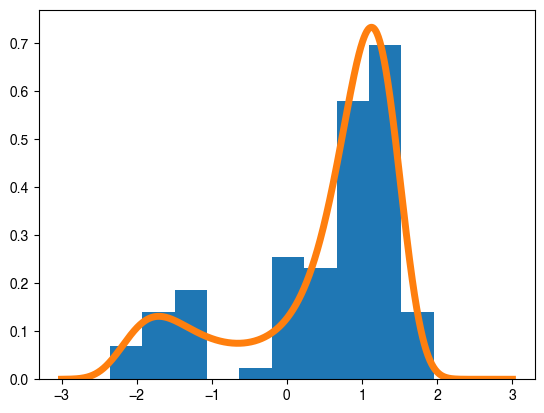

In [26]:
plt.hist(data,density=True)

fit_c,fit_h,fit_d,fit_numu = result.x

xs = np.linspace(-3,3,1000)
mu = np.mean(data)
Jnu = 1./np.var(data)
Z = landauAnalysis.normalizationZ(Jnu,fit_c,fit_h,fit_d)

fit_distribution = [ np.exp(landauAnalysis.LandauTransitionDistributionRelativeLogPDF(x-fit_numu,mu,Jnu,fit_c,fit_h,fit_d))/Z for x in xs ]
plt.plot(xs,fit_distribution,lw=5);

In [27]:
result.fun

113.59366828488983

In [30]:
reload(landauAnalysis)

<module 'landauAnalysis' from '/Users/bdaniel6/packages/landau/landau/landauAnalysis.py'>

In [31]:
landauAnalysis.GaussianDistributionLogPDF(0,mu,Jnu)

-1.078067599084989